# Training a Summarization Model with Unstructured + Argilla + Huggingface

In this notebook, we'll show you how you can use [`unstructured`](https://github.com/Unstructured-IO/unstructured), [`argilla`](https://github.com/argilla-io/argilla), and HuggingFace [`transformers`](https://github.com/huggingface/transformers) to train a custom summarization model. In this case, we're going to build a summarization model targeted at summarizing the [Institute for the Study of War's](https://www.understandingwar.org/) daily reports on the war in Ukraine. You can see an example of one of the reports [here](https://www.understandingwar.org/backgrounder/russian-offensive-campaign-assessment-december-12), and a screen shot appears below.

Combining the `unstructured`, `argilla`, and `transformers` libraries, we're able to complete a data science project that previously could have taken a week or more in just a few hours!

#### Table of Contents

- [Section 1: Data Collection and Staging with `unstructured`](#collection)
- [Section 2: Label Verification with `argilla`](#verification)
- [Section 3: Model Training with `transformers`](#training)

In [1]:
from IPython.display import Image

Image(filename="img/isw.png", width=800) 

## Section 1: Data Collection and Staging with `unstructured` <a id="collection"></a>

In [2]:
import calendar
from datetime import datetime
import re
import time

import requests
from transformers import pipeline
import tqdm

import argilla as rg

from unstructured.partition.html import partition_html
from unstructured.documents.elements import NarrativeText, ListItem
from unstructured.staging.argilla import stage_for_argilla

First, we'll pull our documents from the ISW website. We'll use the built-in Python `datetime` and `calendar` libraries to iterate over the dates for the reports we want to pull and fine the associated URLs.

In [3]:
ISW_BASE_URL = "https://www.understandingwar.org/backgrounder/russian-offensive-campaign-assessment"

def datetime_to_url(dt):
    month = dt.strftime("%B").lower()
    return f"{ISW_BASE_URL}-{month}-{dt.day}"

In [4]:
urls = []
year = 2022
for month in range(3, 13):
    _, last_day = calendar.monthrange(year, month)
    for day in range(1, last_day + 1):
        dt = datetime(year, month, day)
        urls.append(datetime_to_url(dt))

Once we have the URLs, we can pull the HTML document for each report from the web using the `requests` library. Normally, you'd need to write custom HTML parsing code using a library like `lxml` or `beautifulsoup` to extract the narrative text from the webpage for model training. With the `unstructured` library, you can simply call the `partition_html` function to extract the content of interest.

In [5]:
def url_to_elements(url):
    r = requests.get(url)
    if r.status_code != 200:
        return None
        
    elements = partition_html(text=r.text)    
    return elements

After partitioning the document, we'll extract the `Key Takeaways` section from the ISW reports, which is shown in the screenshot below. The `Key Takeaways` section will serve as the target text for our summarization model. While it would be time consuming the write HTML parsing code to find this content, with the `unstructured` library it is easy. Since the `partition_html` function breaks down the elements of the document into different categories like `Title`, `NarrativeText`, and `ListItem`, all we need to do is find the `Key Takeaways` title and then grab `ListItem` elements until the list ends. This logic is implemented in the `get_key_takeaways` function.

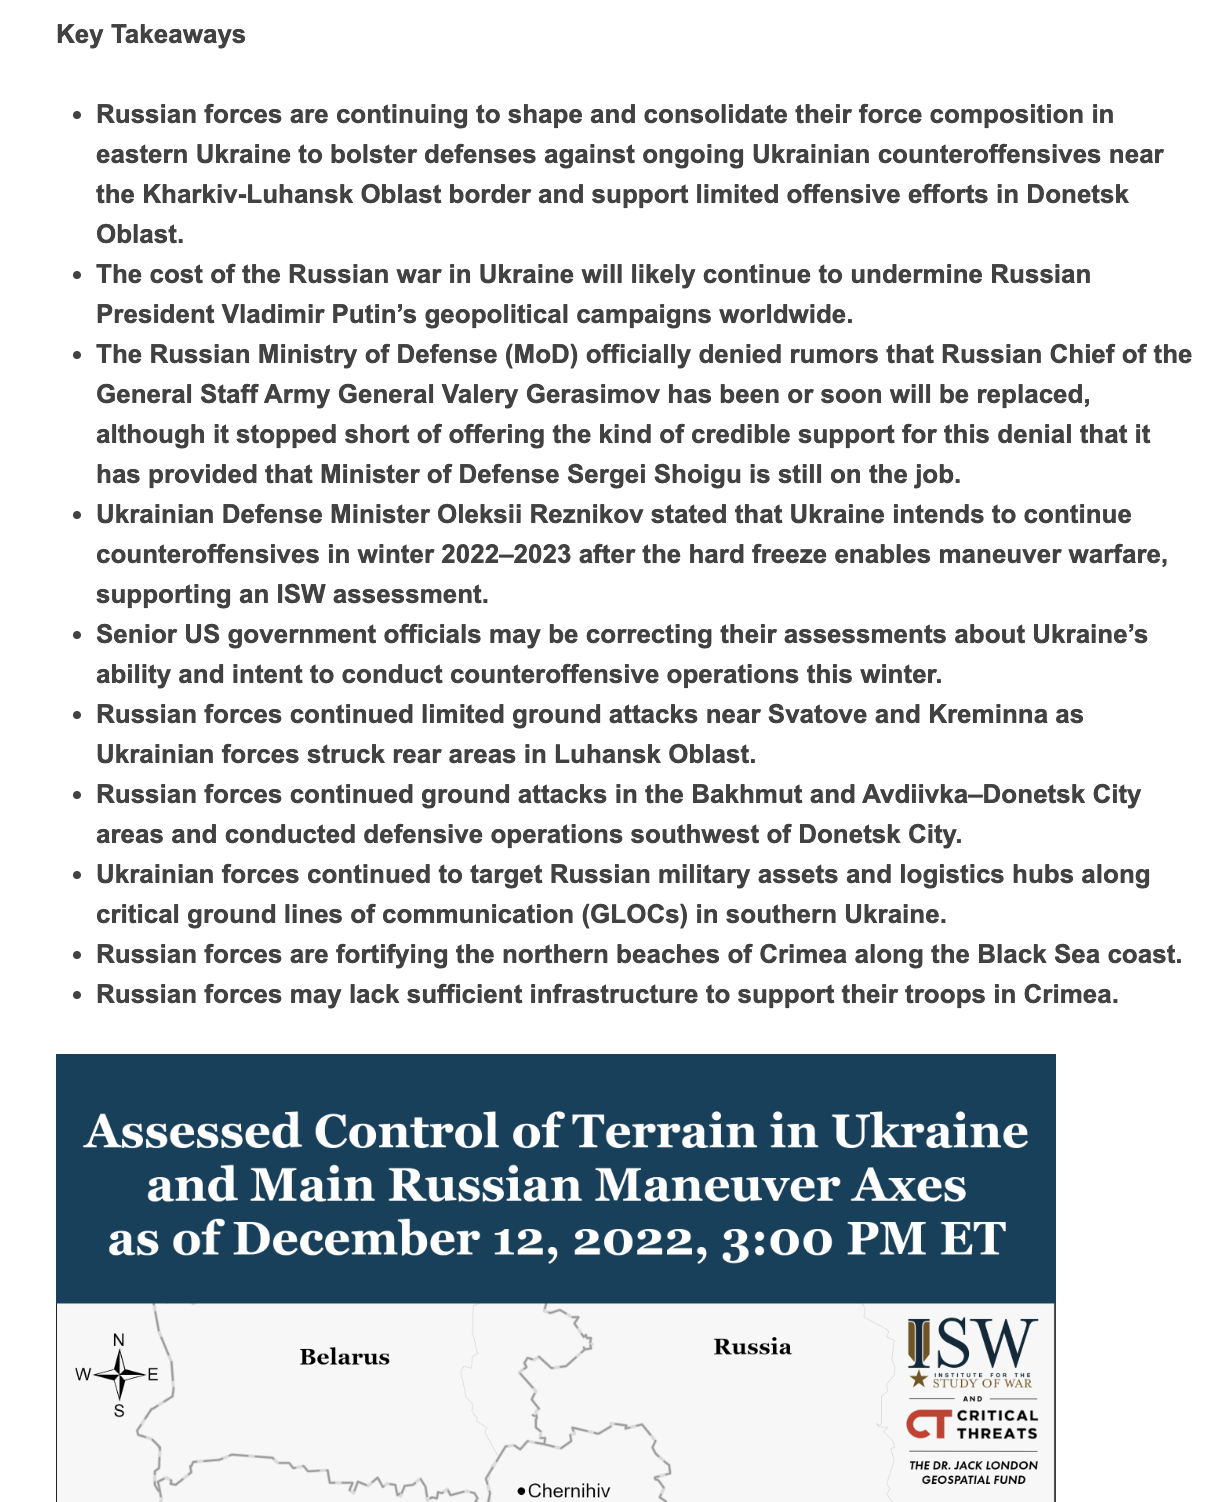

In [6]:
Image(filename="img/isw-key-takeaways.png", width=500) 

In [7]:
def _find_key_takeaways_idx(elements):
    for idx, element in enumerate(elements):
        if element.text == "Key Takeaways":
            return idx

def get_key_takeaways(elements):
    key_takeaways_idx = _find_key_takeaways_idx(elements)
    if not key_takeaways_idx:
        return None
    
    takeaways = []
    for element in elements[key_takeaways_idx + 1:]:
        if not isinstance(element, ListItem):
            break
        takeaways.append(element)

    takeaway_text = " ".join([el.text for el in takeaways])
    return NarrativeText(text=takeaway_text)

In [8]:
elements = url_to_elements(urls[200])

In [9]:
print(get_key_takeaways(elements))

Russian forces continue to prioritize strategically meaningless offensive operations around Donetsk City and Bakhmut over defending against continued Ukrainian counter-offensive operations in Kharkiv Oblast. Ukrainian forces liberated a settlement southwest of Lyman and are likely continuing to expand their positions in the area. Ukrainian forces continued to conduct an interdiction campaign in Kherson Oblast. Russian forces continued to conduct unsuccessful assaults around Bakhmut and Avdiivka. Ukrainian sources reported extensive partisan attacks on Russian military assets and logistics in southern Zaporizhia Oblast. Russian officials continued to undertake crypto-mobilization measures to generate forces for war Russian war efforts. Russian authorities are working to place 125 “orphan” Ukrainian children from occupied Donetsk Oblast with Russian families.


Next we'll grab the narrative text from the document as input for our model. Again, this is easy with `unstructured` because the `partition_html` function already splits out the text. We'll just grab all of the `NarrativeText` elements that exceed a minimum length threshold. While we're in there, we'll also clean out the raw text for citations within the document, which isn't natural language and could impact the quality of our summarization model.

In [10]:
def get_narrative(elements):
    narrative_text = ""
    for element in elements:        
        if isinstance(element, NarrativeText) and len(element.text) > 500:
            # NOTE: Removes citations like [3] from the text
            element_text = re.sub("\[\d{1,3}\]", "", element.text)
            narrative_text += f"\n\n{element_text}"
        
    return NarrativeText(text=narrative_text.strip())

In [11]:
print(get_narrative(elements))

Russian forces continue to conduct meaningless offensive operations around Donetsk City and Bakhmut instead of focusing on defending against Ukrainian counteroffensives that continue to advance. Russian troops continue to attack Bakhmut and various villages near Donetsk City of emotional significance to pro-war residents of the Donetsk People’s Republic (DNR) but little other importance. The Russians are apparently directing some of the very limited reserves available in Ukraine to these efforts rather than to the vulnerable Russian defensive lines hastily thrown up along the Oskil River in eastern Kharkiv Oblast. The Russians cannot hope to make gains around Bakhmut or Donetsk City on a large enough scale to derail Ukrainian counteroffensives and appear to be continuing an almost robotic effort to gain ground in Donetsk Oblast that seems increasingly divorced from the overall realities of the theater.

Russian failures to rush large-scale reinforcements to eastern Kharkiv and to Luhan

Now the we have everything set up, let's collect all of the reports! This step could take a while, we added a sleep call to the loop to avoid overwhelming ISW's webpage.

In [12]:
inputs = []
annotations = []
for url in tqdm.tqdm(urls):
    elements = url_to_elements(url)
    if url is None or not elements:
        continue
    
    text = get_narrative(elements)
    annotation = get_key_takeaways(elements)
    
    if text and annotation:
        inputs.append(text)
        annotations.append(annotation.text)
    # NOTE: Sleeping to reduce the volume of requests to ISW
    time.sleep(1)

100%|████████████████████████████████████████████████████████████████████| 306/306 [05:52<00:00,  1.15s/it]


## Label Verification with `argilla` <a id="verification"></a>

Now that we've collected the data and prepared it with `unstructured`, we're ready to work on our data labels in `argilla`. First, we'll use the `stage_for_argilla` staging brick from the `unstructured` library. This will automatically convert our dataset to a `DatasetForText2Text` object, which we can then import into Argilla.

In [13]:
dataset = stage_for_argilla(inputs, "text2text", annotation=annotations)

In [14]:
dataset.to_pandas().head()

,text,prediction,prediction_agent,annotation,annotation_agent,id,metadata,status,event_timestamp,metrics,search_keywords
0,Russian forces are completing the reinforcemen...,None,None,Russian forces are setting conditions to envel...,None,1c728c08b07bf47c5ec573bf78350c50,{},Validated,None,None,None
1,Russian forces resumed offensive operations in...,None,None,Russian forces resumed offensive operations ag...,None,e03b12744a53d8393620c617b5d82f27,{},Validated,None,None,None
2,The Russian military has continued its unsucce...,None,None,Russian forces opened a new line of advance fr...,None,1852425c2dc32a35274b2ac112b43221,{},Validated,None,None,None
3,Russian forces continue their focus on encircl...,None,None,Russian forces have advanced rapidly on the ea...,None,9f094b6a9d30b9529aa630d818d143ae,{},Validated,None,None,None
4,Russian forces remain deployed in the position...,None,None,Russian forces conducted no major offensive op...,None,d4c88cb002d4fa75d7273c3206cbde93,{},Validated,None,None,None


After staging the data for argilla, we can call the `rg.log` function from the `argilla` Python library to upload the data to the Argilla UI. Before running this step, ensure that you have Argilla running in the background. You can do that by running the following commands in your terminal:

- `docker run -d --name elasticsearch-for-argilla -p 9200:9200 -p 9300:9300 -e "ES_JAVA_OPTS=-Xms512m -Xmx512m" -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch-oss:7.10.2`
- `python -m argilla`

The first command starts the ElasticSearch backend for Argilla and the second command launches the webapp. Once it's running, navigate to `http://0.0.0.0:6900/` and enter `argilla` as the username and `1234` as the password. See the [Quickstart](https://docs.argilla.io/en/latest/getting_started/quickstart.html) instructions from the Argilla docs if you need help getting up and running. After logging the data to Argilla, your UI should look like the screenshot below.

In [15]:
rg.log(dataset, name="isw-summarization")

  0%|          | 0/269 [00:00<?, ?it/s]

269 records logged to http://localhost:6900/datasets/argilla/isw-summarization


BulkResponse(dataset='isw-summarization', processed=269, failed=0)

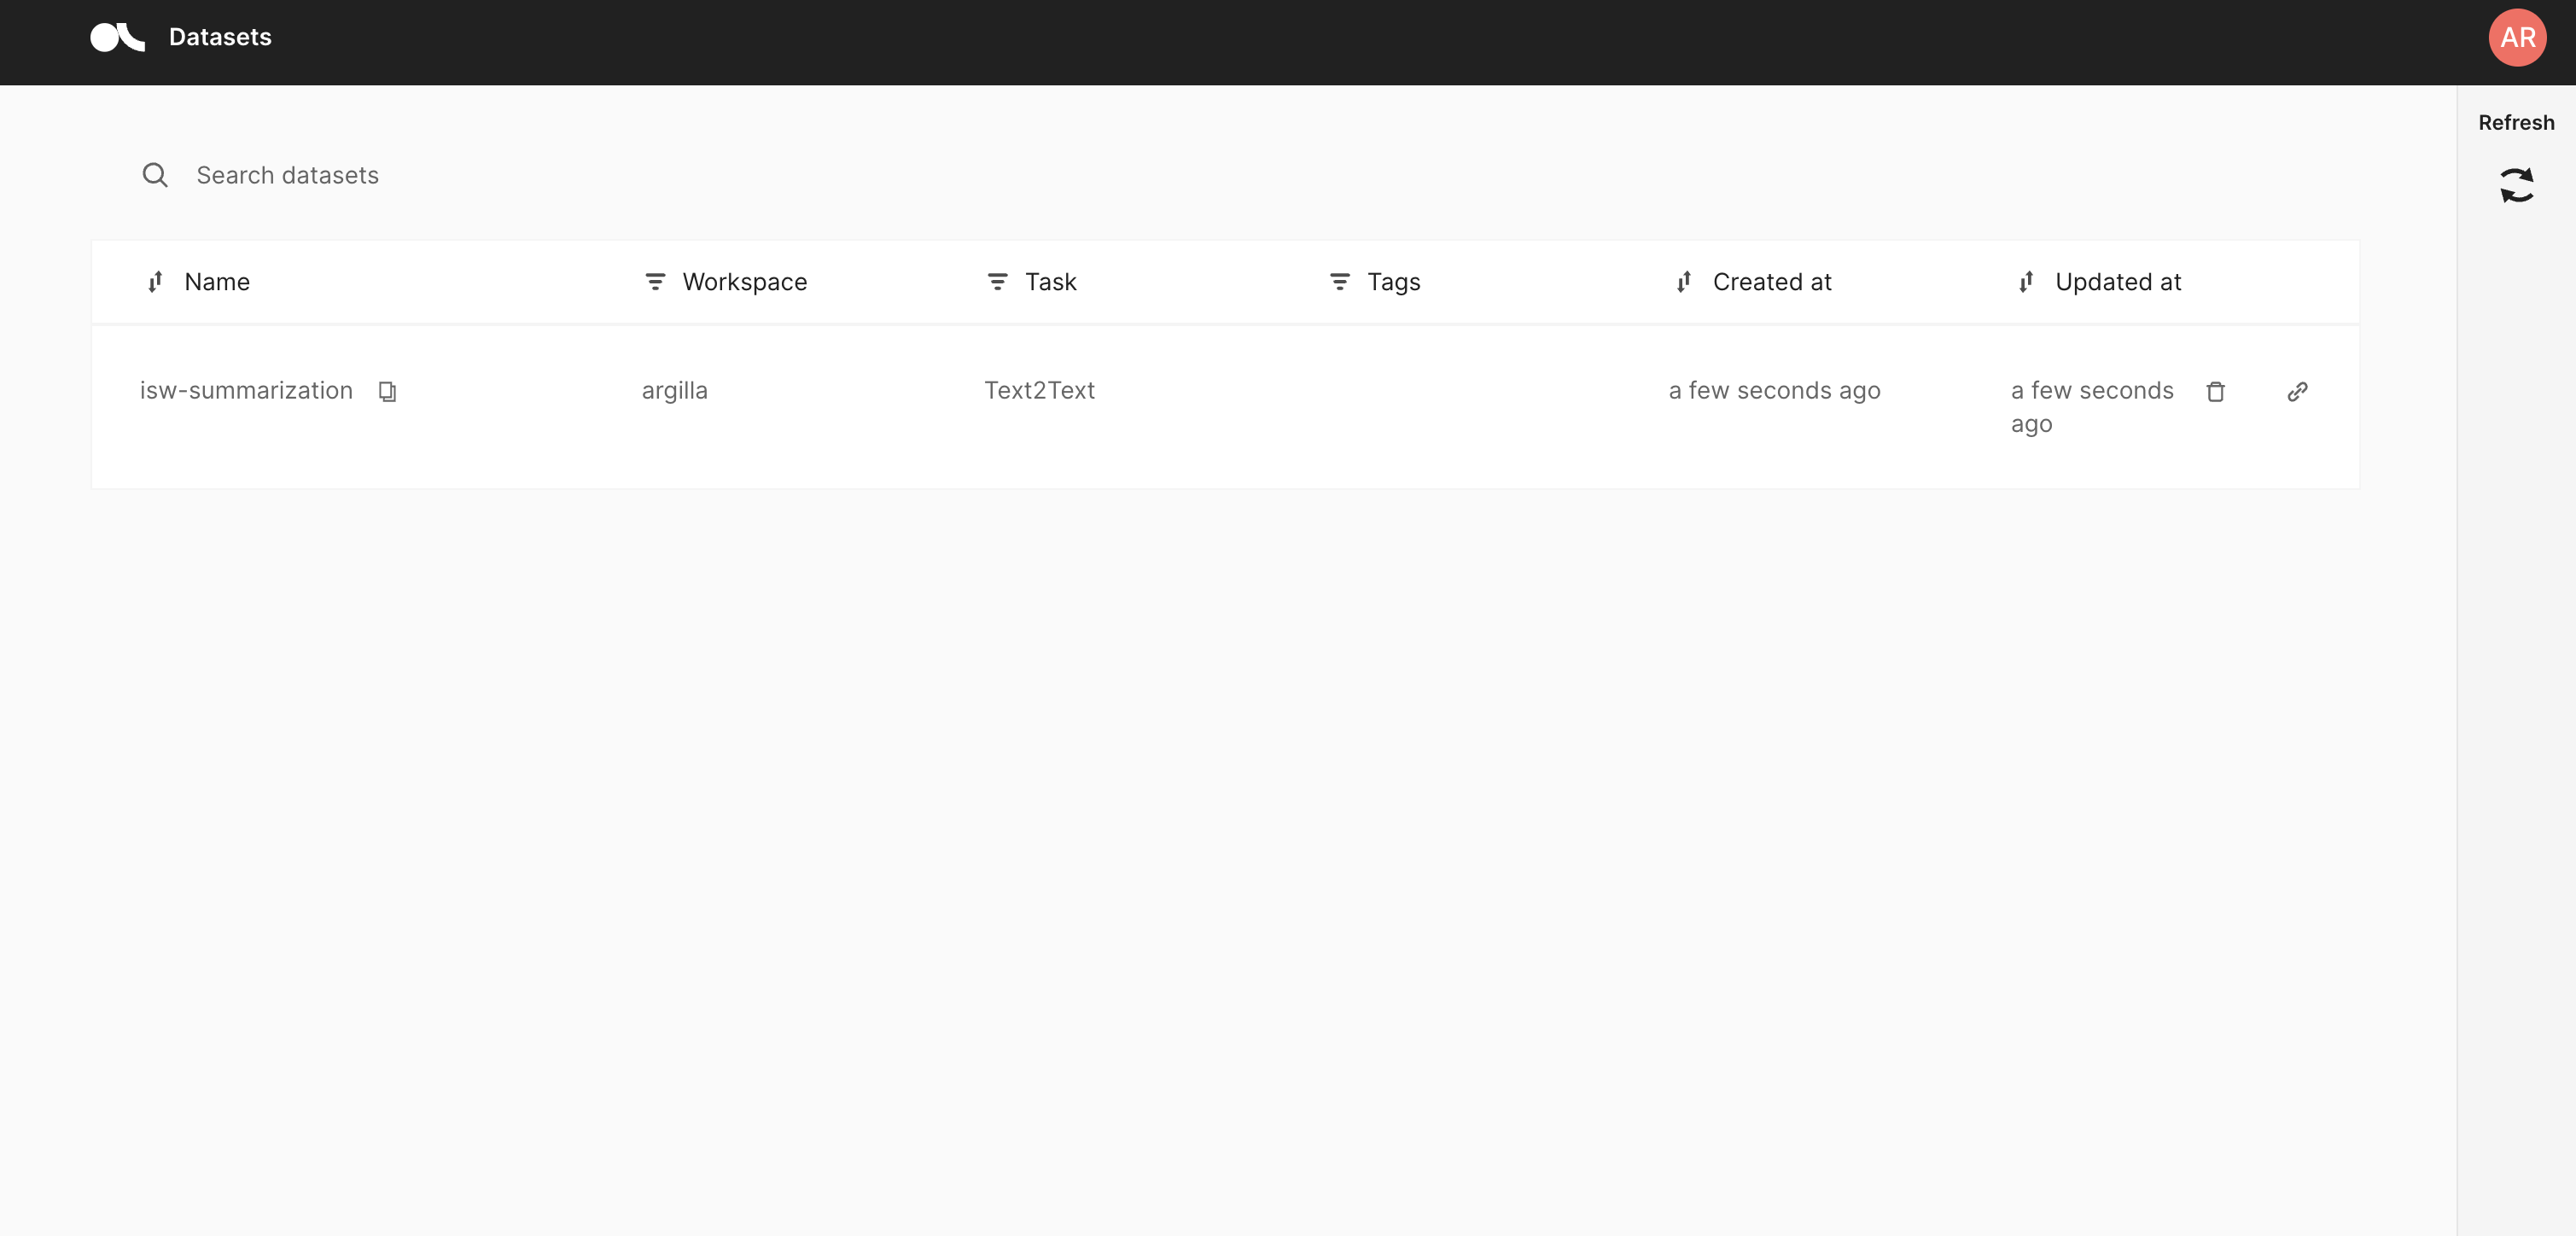

In [16]:
Image(filename="img/argilla-dataset.png", width=800) 

After uploading the dataset, head over to the Argilla UI and validate and/or adjust the summaries we pulled from the ISW site. You can also check out the [`argilla` docs](https://docs.argilla.io/en/latest/reference/python/index.html) for more information on all of the exciting tools Argilla provides to help you evaluate and refine your training data!

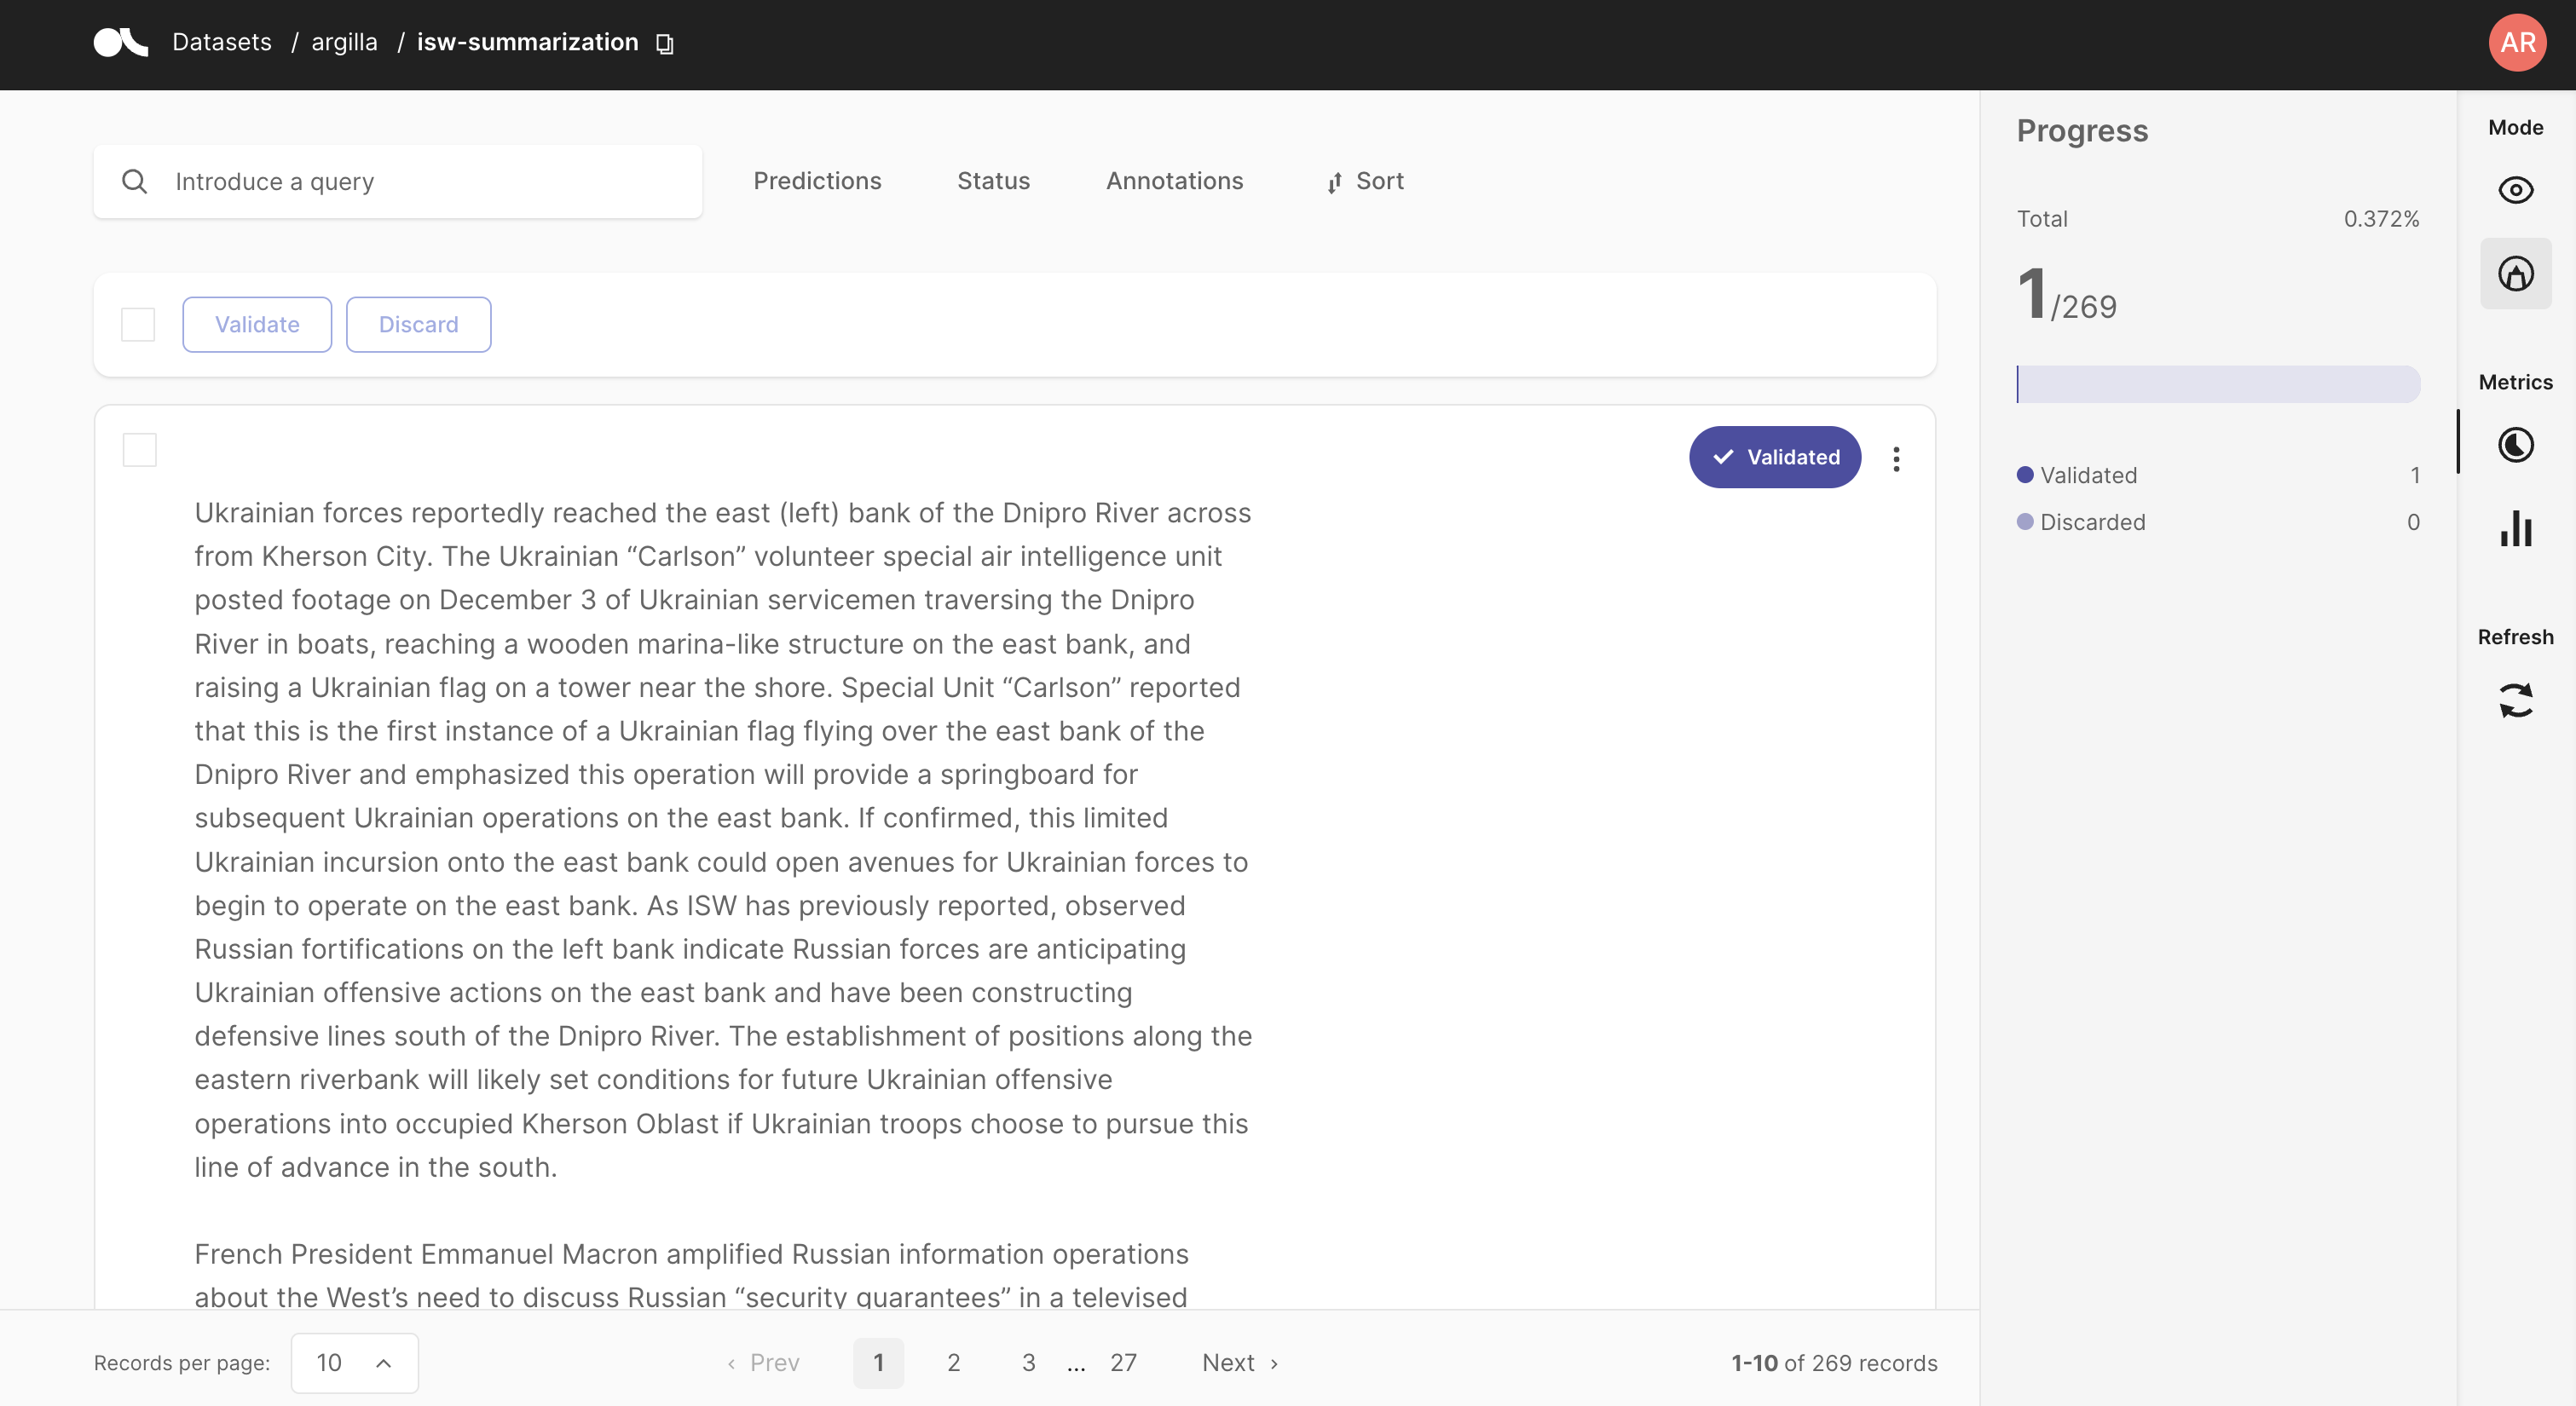

In [17]:
Image(filename="img/argilla-annotation.png", width=800) 

## Section 3: Model Training with `transformers` <a id="training"></a>

After refining our traning data in Argilla, we're ready to fine-tune our model using the `transformers` library. Luckily, `argilla` has a utility for converting datasets to a `dataset.Dataset`, which is the format required by the `transformers` `Trainer` object. In this example, we'll train a `t5-small` model to keep the runtime for the notebook reasonable. You can play around with larger models to get higher quality results.

In [18]:
training_data = rg.load("isw-summarization").to_datasets()

In [19]:
model_checkpoint = "t5-small"

In [20]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/Users/mrobinson/.pyenv/versions/3.8.13/envs/argilla/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [21]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["annotation"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [22]:
tokenized_datasets = training_data.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

/Users/mrobinson/.pyenv/versions/3.8.13/envs/argilla/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [23]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [24]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    "t5-small-isw-summaries",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [26]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [27]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, metrics, annotation_agent, prediction, prediction_agent, metadata, annotation, status, text, event_timestamp. If id, metrics, annotation_agent, prediction, prediction_agent, metadata, annotation, status, text, event_timestamp are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/mrobinson/.pyenv/versions/3.8.13/envs/argilla/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  

Epoch,Training Loss,Validation Loss
1,No log,4.039025


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, metrics, annotation_agent, prediction, prediction_agent, metadata, annotation, status, text, event_timestamp. If id, metrics, annotation_agent, prediction, prediction_agent, metadata, annotation, status, text, event_timestamp are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 269
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=17, training_loss=4.375706840963924, metrics={'train_runtime': 375.947, 'train_samples_per_second': 0.716, 'train_steps_per_second': 0.045, 'total_flos': 72813889191936.0, 'train_loss': 4.375706840963924, 'epoch': 1.0})

In [28]:
trainer.save_model("t5-small-isw-summaries")

Saving model checkpoint to t5-small-isw-summaries
Configuration saved in t5-small-isw-summaries/config.json
Model weights saved in t5-small-isw-summaries/pytorch_model.bin
tokenizer config file saved in t5-small-isw-summaries/tokenizer_config.json
Special tokens file saved in t5-small-isw-summaries/special_tokens_map.json


In [29]:
summarization_model = pipeline(
task="summarization",
model="./t5-small-isw-summaries",
)

loading configuration file ./t5-small-isw-summaries/config.json
Model config T5Config {
  "_name_or_path": "./t5-small-isw-summaries",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de"

Now that our model is trained, we can save it locally and use our `unstructured` helper functions to grab future reports for inference!

In [30]:
elements = url_to_elements(urls[200])
narrative_text = get_narrative(elements)
results = summarization_model(str(narrative_text), max_length=100)
print(results[0]["summary_text"])

Russian forces continue to attack Bakhmut and various villages near Donetsk City . the Russians are apparently directing some of the very limited reserves available in Ukraine to these efforts rather than to the vulnerable Russian defensive lines hastily thrown up . Russian sources claimed that Russian forces are repelled a Ukrainian ground attack on Pravdyne .
